In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
processed_dataset  = "processed_data"

# Neural networks micro framework

In [3]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.lax import dynamic_slice

In [4]:
def conv3D(grid,W):
    G = grid.copy()
    def relu(x):
        return jnp.maximum(0,x)
    
    # put zeros "around"
    G = jnp.pad(G,int(W.shape[0]/2))
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        ( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[1] / 2.), k - int(W.shape[2] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[2] / 2.) ,G.shape[2] - int(W.shape[2] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[1] / 2.), G.shape[1] - int(W.shape[1] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        
    return G
conv3D = jax.jit(conv3D)

In [5]:
def relu(x,w = 1.,b = 0.):
    return jnp.maximum(0,x * w + b)

def sigmoid(x,w = 1.,b = 0.):
    return (jnp.tanh(x * w + b) + 1.)/2.

def tanh(x,w=1.,b=0.):
    return jnp.tanh(x * w + b)

In [6]:
def linear(layer,W,b):
    return W @ layer + b

def add(layer,b):
    return layer + b

# Loading npy(s)

In [7]:
import os
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []


for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(voxelization)
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
10 su 101
20 su 101
30 su 101
40 su 101
50 su 101
60 su 101
70 su 101
80 su 101
90 su 101
100 su 101


In [8]:
shapes      = np.array([ np.array(a.shape) for a in voxelizations ])
magic_shape = shapes.max(axis = 0)
magic_shape

array([74, 66, 81])

## Conversione dei dati caricati in formato array

In [9]:
voxelizations       = [ jnp.array(o) for o in voxelizations      ]
voxelization_specs  = [ jnp.array(o) for o in voxelization_specs ]
centers_of_mass     = [ jnp.array(o) for o in centers_of_mass    ]
finger_prints       = [ jnp.array(o) for o in finger_prints      ]

# Center of mass gaussianization

In [10]:
def center_of_mass_gaussianization(
        com,                      # centro di massa
        voxelization_orig_shape , # dimensione della voxelizzazione prima di essere paddata
        voxelization_specs      , # specifiche geometriche della voxelizzazioen (xmin,xmax,ymin,ymax,zmin,zmax)
        sigma = 5.                # deviazione standard della gaussiana
):
    # ritorna una voxelgrid in cui il centro di massa é rappresentato attraverso una gaussiana 
    # di varianza sigma_sq
    
    grid = np.zeros((voxelization_orig_shape[0],
                     voxelization_orig_shape[1],
                     voxelization_orig_shape[2]))
    
    x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs

    X   = jnp.linspace(x_min,x_max, voxelization_orig_shape[0])
    Y   = jnp.linspace(y_min,y_max, voxelization_orig_shape[1])
    Z   = jnp.linspace(z_min,z_max, voxelization_orig_shape[2])
    
    # faccio il meshgrid dei linspace
    XYZ = jnp.meshgrid(X,Y,Z, indexing = 'ij')

    
    grid =  jax.vmap(
                        lambda x,y,z: 
                            jnp.exp( - (
                                        (x - com[0])**2 +      
                                        (y - com[1])**2 + 
                                        (z - com[2])**2
                                       ) / (sigma**2)           # divido per la varianza
                                   )
                    )(XYZ[0],
                      XYZ[1],
                      XYZ[2])


    grid = np.array(grid)
    return grid
    

In [11]:
voxelization_specs[0]

DeviceArray([-1.307, 26.864, -9.073, 20.774, 13.342, 41.422], dtype=float32)

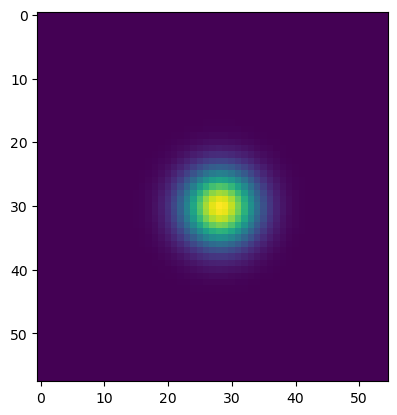

In [12]:
com_g = center_of_mass_gaussianization(
    centers_of_mass[0],
    voxelizations[0].shape,
    voxelization_specs[0],
    3.
)
plt.imshow(com_g.mean(axis = 0))

# Padding

In [13]:
def padding(array, requested_shape):
    xx = requested_shape[0]
    yy = requested_shape[1]
    zz = requested_shape[2]
    
    sa = array.shape[0]
    sb = array.shape[1]
    sc = array.shape[2] 
    
    a = (xx - sa) // 2
    aa = xx - a - sa
    b = (yy - sb) // 2
    bb = yy - b - sb
    c = (zz - sc) // 2
    cc = zz - c - sc
    
    return jnp.pad(array, pad_width=((a, aa), (b, bb), (c,cc)), mode='constant')

# Data Augmentation

La classe augmentation contiene una collezione di funtori.
Ognuno di questi funtori viene inizializzato prendendo in ingresso <br>
    1.<code>voxelization</code> <br>
    2.<code>gaussianized center of mass </code> <br>
estraendo da questi informazionin  riguardanti la data augmentation. <br>
Le principali data augmentation sono le seguenti
    1.<code>Identity</code> <br>
    2.<code>Translation</code> <br>
    3.<code>Gaussian Erosion</code> ( data una gaussianizzazione di un centro di massa, ogni voxel $V_{ijk}$ ha probabilitá $1 - g_{ijk}$ di essere flippato) <br>
    4.<code>Concatenate</code>

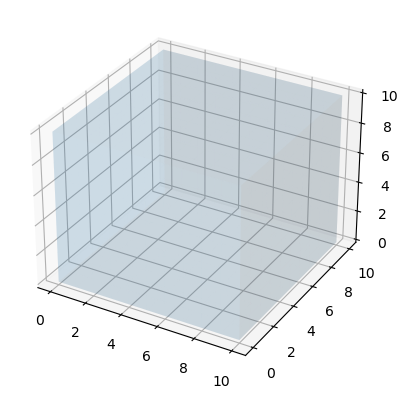

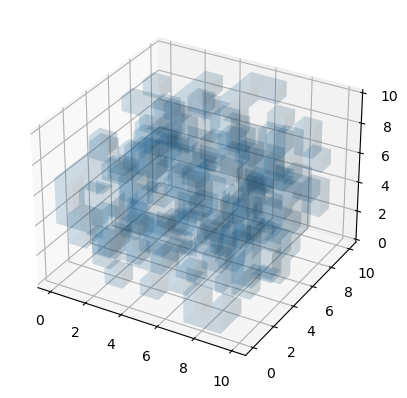

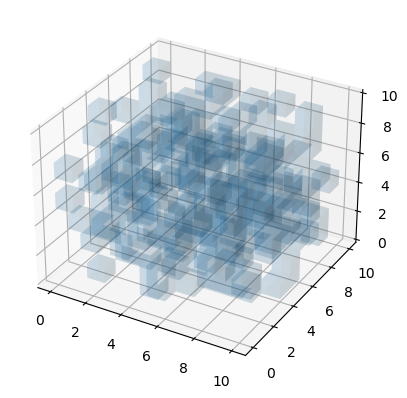

In [233]:
key = jax.random.PRNGKey(758493)  # Random seed is explicit in JAX
class Augmentation:
    class Identity:
        def __init__(self,vox,com):
            0 # nothing to do...
        def __call__(self,x):
            return x
        
    class Translation:
        def __init__(self,vox,com):
            vox_mean      = (np.array(vox.shape) / 2).astype(int)
            self.r_vector = ((np.random.uniform(size = 3) * np.array(vox.shape))).astype(int) - vox_mean
            
        def __call__(self, x):
            r_x = self.r_vector[0]
            r_y = self.r_vector[1]
            r_z = self.r_vector[2]
            
            v_x = x.shape[0]
            v_y = x.shape[1]
            v_z = x.shape[2]
            
            
            if r_x > 0:    # traslazione positiva
                x = jnp.concatenate([x, jnp.zeros((r_x,v_y,v_z))], axis = 0)
                x = x[r_x:,:,:]
            else:          # traslazione negativa
                if r_x < 0:
                    r_x *= -1
                    x = jnp.concatenate([jnp.zeros((r_x,v_y,v_z)), x], axis = 0)
                    x = x[:-r_x,:,:]       
            
            if r_y > 0:
                x = jnp.concatenate([x, jnp.zeros((v_x,r_y,v_z))], axis = 1)
                x = x[:,r_y:,:]
            else:
                if r_y < 0:
                    r_y *= -1
                    x = jnp.concatenate([jnp.zeros((v_x,r_y,v_z)),x], axis = 1)
                    x = x[:,:-r_y,:]    
            
            if r_z > 0:
                x = jnp.concatenate([x, jnp.zeros((v_x,v_y,r_z))], axis = 2)
                x = x[:,:,r_z:]
            else:
                if r_z < 0:
                    r_z *= -1
                    x = jnp.concatenate([jnp.zeros((v_x,v_y,r_z)), x], axis = 2)
                    x = x[:,:,:-r_z]
                
            return x
        
    class GaussianErosion:
        def __init__(self,vox,com):
            com_flat = com.flatten()
            self.vox_shape = vox.shape
            self.prob_flat = (1 - com).flatten()
        
        def __call__(self, x):
            xor            = lambda x,y : x + y - 2 * x * y
            extraction     = np.random.uniform(size = len(self.prob_flat)) < self.prob_flat
                             
            extraction     = extraction.reshape(self.vox_shape)
            return         xor(extraction, x)
            
            # flip_bit  old_bit  new_bit
            #    0         0       0            // XOR
            #    0         1       1
            #    1         0       1
            #    1         1       0
    

                    
th  = 0.5
        
img = np.ones( (10,10,10) )
com = center_of_mass_gaussianization(
            np.zeros(3),
            img.shape,
            np.array([-10,10,-10,10,-10,10]),
            sigma = 10.
)


ax = plt.figure().add_subplot(projection = '3d')
ax.voxels(img > th, alpha = 0.1)
plt.show()

T = Augmentation.GaussianErosion

ax = plt.figure().add_subplot(projection = '3d')
transformed_img = T(img,com)(img)
ax.voxels(np.array(transformed_img) > th, alpha = 0.1)
plt.show()

ax = plt.figure().add_subplot(projection = '3d')
transformed_img = T(img,com)(img)
ax.voxels(np.array(transformed_img) > th, alpha = 0.1)
plt.show()

In [238]:
def extract_batch(magic_shape     ,   # magic shape
                  voxel_list      ,   # lista delle voxelizzazioni 
                  voxel_spec_list ,   # lista delle specifiche delle voxelizzazioni
                  com_list        ,   # lista dei centri di massa
                  sigma           ,   # sigma 
                  augmentation    ,   # augmentation routine
                  idx_list):          # lista degli indici da prendere
    
    
    gaussianized_centers =  [
                center_of_mass_gaussianization(
                                    com_list[idx],
                                    voxel_list[idx].shape,
                                    voxel_spec_list[idx],
                                    sigma
                                )
        for idx in idx_list
    ]
    
    Ts = [
            jax.jit(
                augmentation(
                    voxel_list[idx],
                    g
                )
            )                           # inizializzo oggetti aumentazione per ogni elemento
        for idx,g in zip(idx_list,gaussianized_centers)
    ]
    
    return (
            jnp.array([                                       # padding delle voxelizzazioni
                    T(
                        padding(
                            voxel_list[idx] , 
                            magic_shape
                        )
                    )
                for idx,T in zip(idx_list,Ts)
            ]),
            jnp.array([
                    T(
                        padding(
                            g,
                            magic_shape
                        )
                    )
                for idx,T,g in zip(idx_list,Ts,gaussianized_centers)
            ])
    )

In [241]:
n = 5
vox,com = extract_batch(
    magic_shape,
    voxelizations,
    voxelization_specs,
    centers_of_mass,
    sigma = 7.0,
    augmentation = Augmentation.GaussianErosion,
    idx_list = np.random.choice(len(voxelizations), size = (n**2))
)
print("rendering..")
axs = plt.figure().subplots(n,n).flatten()
for i,a in enumerate(axs):
    a.imshow(com[i].mean(axis = 0))
    

TypeError: add got incompatible shapes for broadcasting: (74, 66, 81), (51, 51, 69).

# Network

###  Rete

In [87]:
def logistic_model(kernels_tensor_flux, 
                   biases_tensor_flux,                   
                   grid):
        
    x            = conv3D(grid, 
                          kernels_tensor_flux[0])
    x            = relu(x ,
                        b = biases_tensor_flux[0])
    
    for W,b in zip(kernels_tensor_flux[1:][:-1], biases_tensor_flux[1:][:-1]):
        x        = conv3D(x,  W)
        x        = relu(x,b = b)
    
    x            = conv3D(x, kernels_tensor_flux[-1])
    x            =    add(x, biases_tensor_flux[-1] )
    
    return x
    

def generate_params_big_model( flux_topology ):
    
    kernels_tensor_flux = []
    biases_tensor_flux  = []
    
    for k in flux_topology:
        kernels_tensor_flux.append( 
            jnp.array(
                np.random.normal(
                    size = (k,k,k)
                ) 
                * 
                np.sqrt(
                    2./ (k * k * k)
                )
            ) 
        )
        biases_tensor_flux.append(0.)

    
    return kernels_tensor_flux, biases_tensor_flux

### Loss function

In [88]:
def loss(    
       kernels_tensor_flux, 
       biases_tensor_flux,
       grid,
       A):
    
    A_hat = logistic_model(
                   kernels_tensor_flux, 
                   biases_tensor_flux,
                   grid)
    
    
    return ((A - A_hat)**2).mean()


loss = jax.jit(loss)
grad = jax.grad(loss,argnums = (0,1))
grad = jax.jit(grad)

In [89]:
def batch_loss(    
                   kernels_tensor_flux, 
                   biases_tensor_flux,
    
                   grids,
                   As):
    
    
        return jax.vmap(
          lambda 
              grid, A:
              (
                  (
                    logistic_model( 
                                    kernels_tensor_flux, 
                                    biases_tensor_flux,
                                    grid
                                   ) 
                     - A)**2 * (A > 0.0)
                   ).mean() / (A > 0.0).mean()
              )(
                  grids,
                  As
              ).mean()
    
batch_loss = jax.jit(batch_loss)
batch_grad = jax.grad(batch_loss,argnums = (0,1))
batch_grad = jax.jit(batch_grad)

# Training

## Random generated parameters

In [106]:
np.random.seed(123)
ktf, btf = generate_params_big_model( [3 for k in range(5)])

## Training Loop

$(1 - T)^E\sigma_0 = \sigma_F$ <br>
$log\left( (1 - T)^E\sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$log\left( (1 - T)^E \right) + log\left( \sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$E log\left( (1 - T) \right) + log\left( \sigma_0 \right) = log \left( \sigma_F \right)$ <br>
$log\left( (1 - T) \right)  = \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right)$ <br>
$\left( (1 - T) \right)  =  exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$<br>
$ -T  =  - 1 + exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$ <br>
$ T  =  1 - exp ( \frac{1}{E} \left( log \left( \sigma_F \right) - log\left( \sigma_0 \right) \right) )$ 
<br>

sigma = 9.54993
0
	0.09151
	0.08736
	0.08895
	0.07933
	0.08319
	0.08302
	0.08643
	0.08174
	0.07203
	0.07309


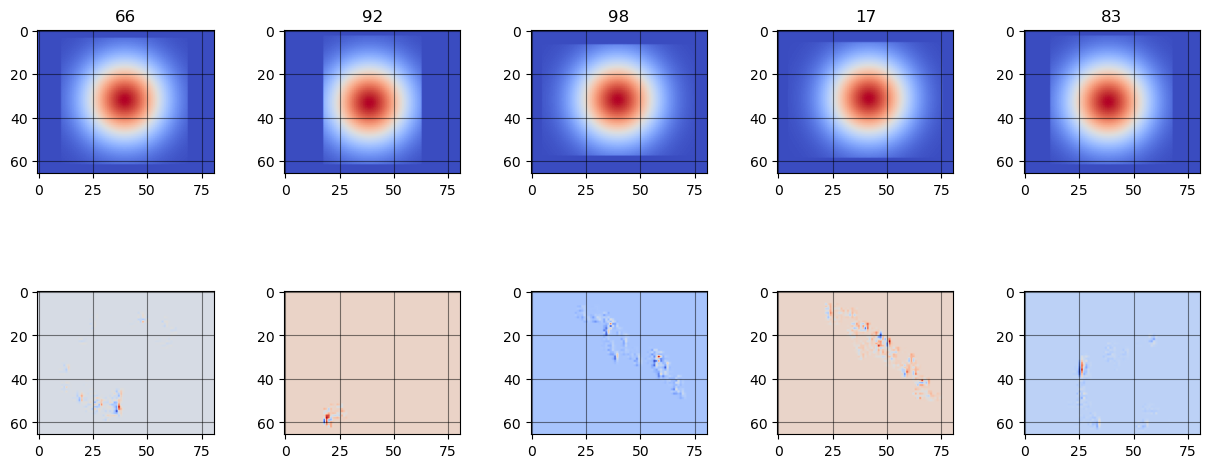

0.08266621
sigma = 9.12011
1
	0.06856
	0.06579
	0.05527
	0.05952
	0.06485
	0.06471
	0.06092
	0.05901
	0.06340
	0.05783


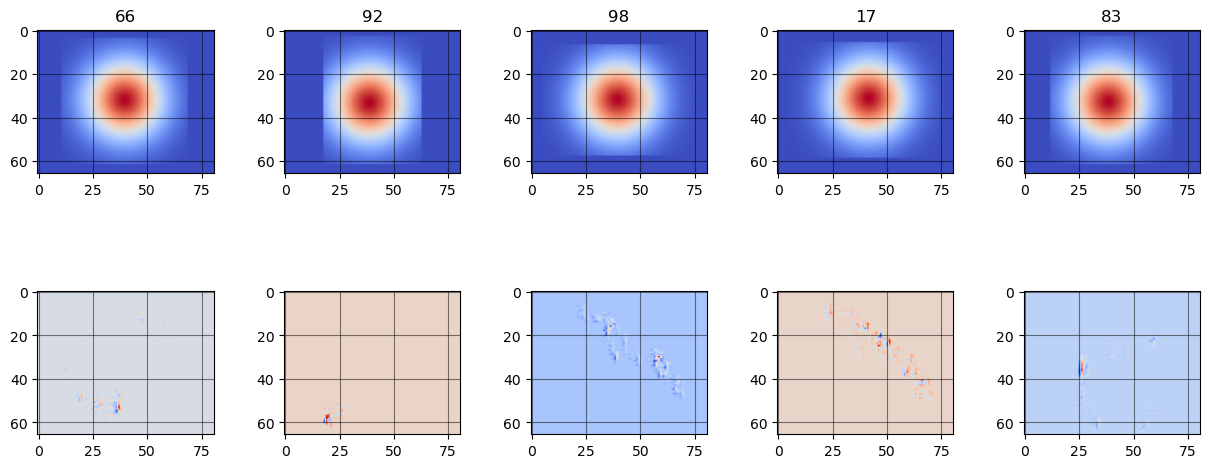

0.061987597
sigma = 8.70964
2
	0.04923
	0.05021
	0.04249
	0.05120
	0.04901
	0.04784
	0.05237
	0.04998
	0.04883
	0.05427


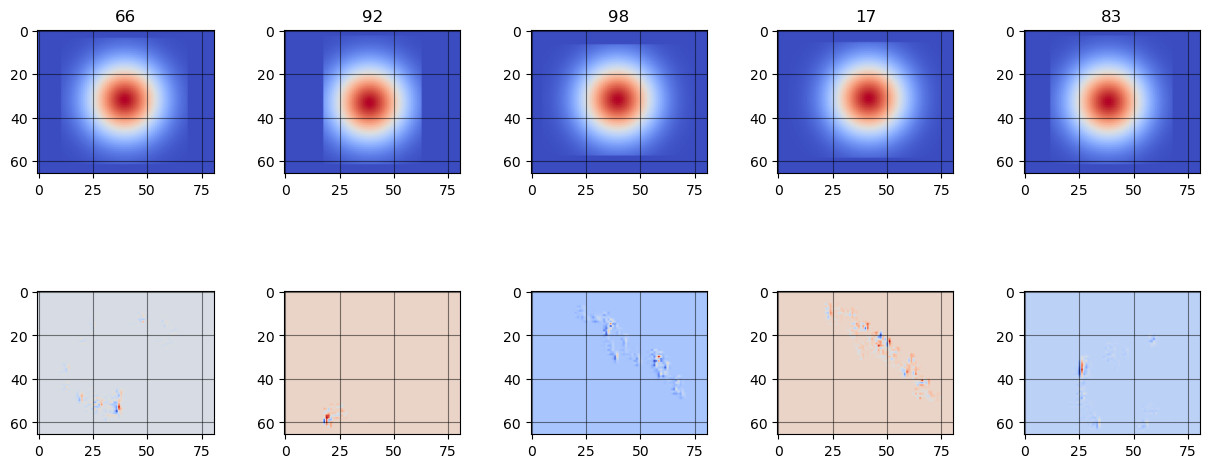

0.049545478
sigma = 8.31764
3
	0.04662
	0.04201
	0.03830
	0.04487
	0.03862
	0.04049
	0.04081
	0.04308
	0.03800
	0.03993


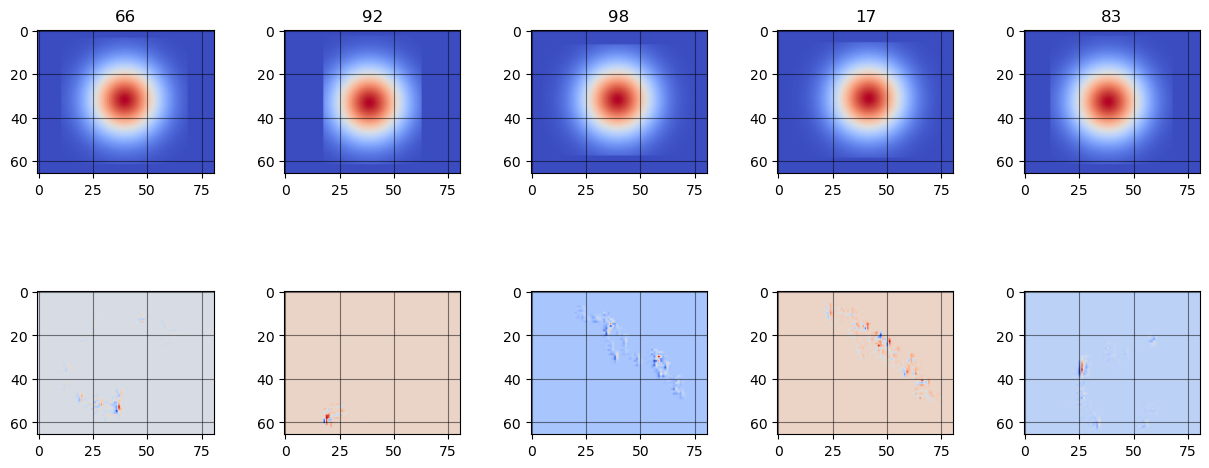

0.041272532
sigma = 7.94328
4
	0.03678
	0.03664
	0.03430
	0.03457
	0.03754
	0.03657
	0.04087
	0.03676
	0.03764
	0.03548


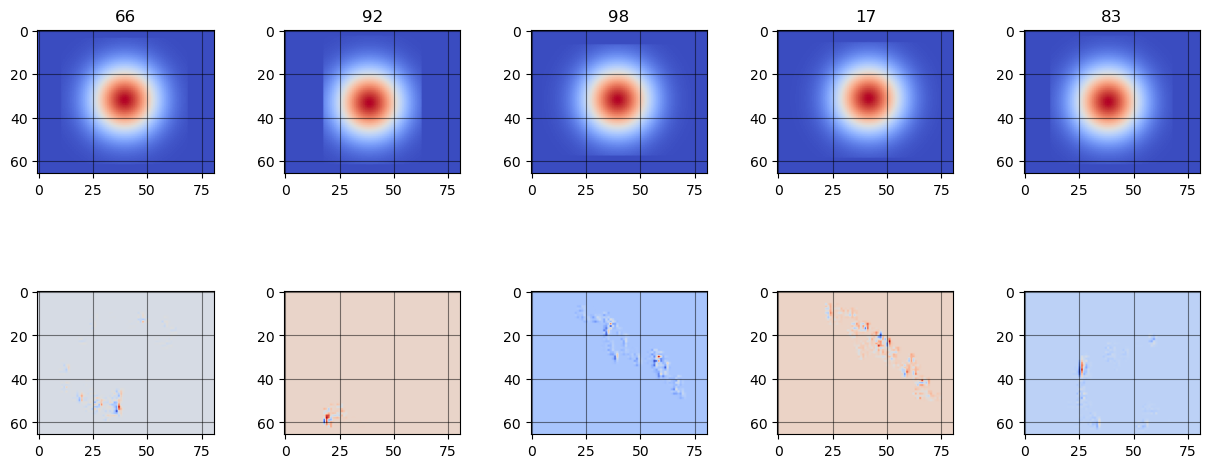

0.036714908
sigma = 7.58578
5
	0.03269
	0.03482
	0.03522
	0.03058
	0.03211
	0.03407
	0.03072
	0.03067
	0.03228
	0.03292


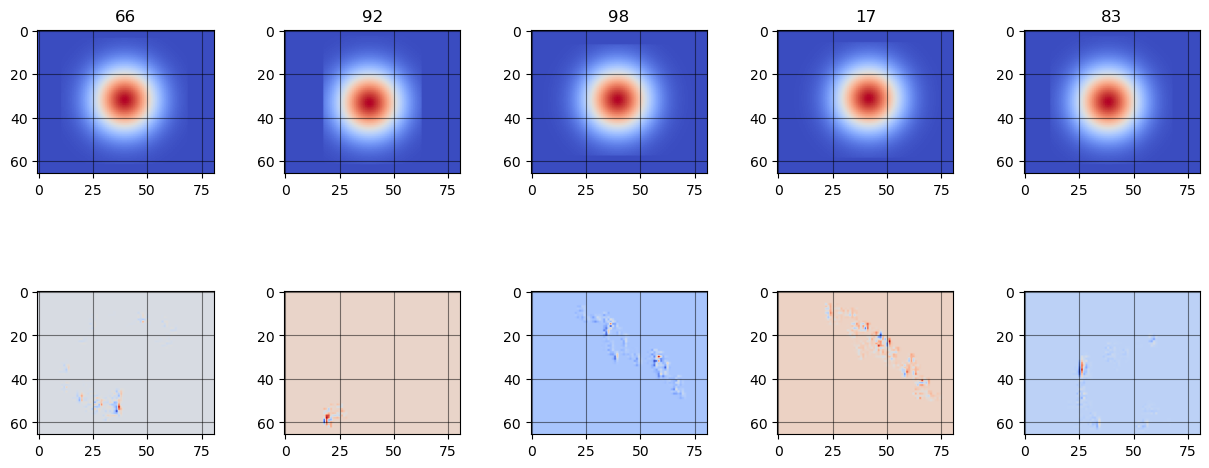

0.032607935
sigma = 7.24436
6
	0.02885
	0.03070
	0.02948
	0.02873
	0.02876
	0.02820
	0.02839
	0.03042
	0.03282
	0.02855


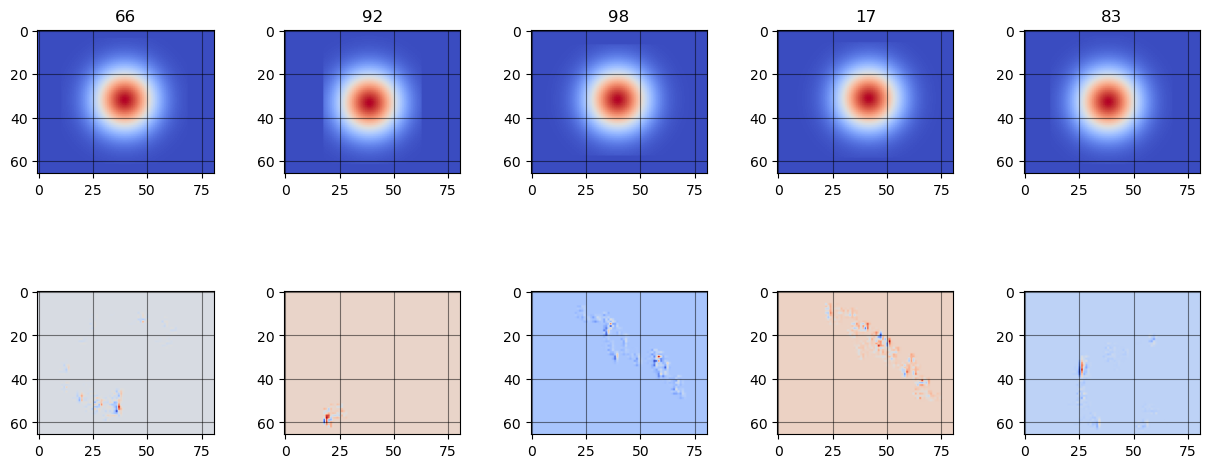

0.029489687
sigma = 6.91831
7


KeyboardInterrupt: 

In [131]:
np.random.seed(123)
errors = []
losses = []

sigma_0 = sigma  = 10.
sigma_F = 1.0
epochs = 50

T      = 1 - np.exp( (1./epochs) * ( np.log(sigma_F) - np.log(sigma_0) )  )
picture_samples = np.random.choice(len(voxelizations), size = 5)

    
for e in range(epochs):
    sigma =  (1 - T) * sigma
    print("sigma = %.5f" % sigma)
    print(e)
    batches_n  = int(np.sqrt(len(voxelizations)))
    
    indici     = np.random.choice(len(voxelizations),
                                  len(voxelizations),
                                  False)
    batches    = np.array_split( indici , batches_n)
    
    
    for batch in batches:
        vox,com = extract_batch(
            magic_shape,
            voxelizations,
            voxelization_specs,
            centers_of_mass,
            sigma = sigma,
            augmentation = Augmentation.Translation,
            idx_list = batch
        )
            
        g      = batch_grad(    ktf,
                                btf,
                                vox,
                                com)
        lr  = 1e-2
        
        ktf = [ k - lr * gr for k,gr in zip(ktf, g[0])]
        btf = [ b - lr * gr for b,gr in zip(btf, g[1])]
        
        curr_loss = batch_loss( ktf,
                                btf,
                                vox,
                                com)
        
        errors.append(curr_loss)
        losses.append(np.mean(errors[-batches_n:]))
        print("\t%.5f" % curr_loss)
        
    #########################################################################################
    
    fetta = 15
    axs = plt.figure(figsize=(15,6)).subplots(2,5)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.4) 

    
    
    vox,com   = extract_batch(
            magic_shape,
            voxelizations,
            voxelization_specs,
            centers_of_mass,
            sigma = sigma,
            augmentation = Augmentation.Identity,
            idx_list =  picture_samples
        )
    
    for img,sample in enumerate(picture_samples):
        axs[0,img].set_title(sample)
        axs[0,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')
        axs[1,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')


        axs[0,img].imshow( com[img][fetta,:,:] , cmap = 'coolwarm')
        
        axs[1,img].imshow( logistic_model(
                                  ktf, 
                                  btf,
                                  vox[img]
                                )[fetta,:,:] , alpha = 1.0, cmap = 'coolwarm' )
    
    plt.show()
    
    
    
    print(losses[-1])
    
    
plt.figure()
plt.plot(losses)

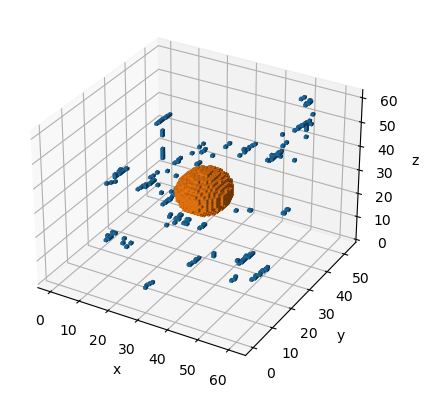

In [130]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax





sample  = 48

vox_obj = voxelizations[sample]
center  = np.array( center_of_mass_gaussianization(
    centers_of_mass[sample],
    voxelizations[sample].shape,
    voxelization_specs[sample],
    5.
) > 0.5 ) * 1.


V_A_hat = np.array(     logistic_model(
                                  ktf, 
                                  btf,
                                  vox_obj
                        )
                  )


ax = make_ax(True)
#ax.voxels( np.array(vox_obj) , edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
ax.voxels( V_A_hat > (0.6 * (V_A_hat.max() - V_A_hat.min()) + V_A_hat.min()) , edgecolors='gray', lw = 0., alpha = 1., shade=True)
ax.voxels( center , edgecolors='gray', lw = 0., alpha = 1., shade=True)
plt.show()

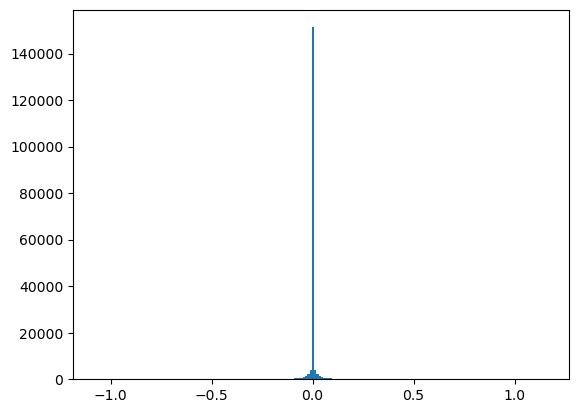

In [121]:
plt.hist(V_A_hat.flatten(), bins = 200)
plt.show()